In [1]:
import os, shutil
import pandas as pd
import numpy as np
import cv2
from collections import Counter
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from scipy.spatial import distance
import math 

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
def weightedL2(a,b,w):
    q = a-b
    return np.sqrt((w*q*q).sum())

In [3]:
def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0]

In [4]:
def preprocessing(filenames):
    
    # read images and build the dataset which contains the features (colors, dimension, center of gravity)
    
    images = []
    images_path = []
    family=[]
    color_B=[]
    color_S=[]
    dimension_S=[]
    center_S=[]

    for fn in filenames:
        #read images
        im = cv2.imread(os.path.join(original_dataset_dir,fn))
        images.append(im)
        #save path
        img_path = os.path.join(original_dataset_dir,fn)
        images_path.append(img_path)
        
        #save geometric family name
        fm=fn.split("_")[0]
        family.append(fm)
        
        image_inline=im.reshape(-1, 3)
        #define unique colors used
        colors, counts = np.unique(image_inline, axis=0, return_counts=True)
        
        npixel_w=im.shape[0] #dimension
        npixel_h=im.shape[1]
        
        #check colors in the corners
        corner_cols=[tuple(im[0,0]),
                     tuple(im[0,npixel_h-1]),
                     tuple(im[npixel_w-1,0]),
                     tuple(im[npixel_w-1,npixel_h-1])
                    ]
        #Background color is the most frequent in the corners
        mf=most_frequent(corner_cols)
        cb=np.array(mf)
    
        #Shape color is the other
        cs=np.array([list(col) for col in colors if list(col)!= list(cb)][0])
    
        #dimension of shape
        ind=np.where((colors == cs).all(axis=1))[0]
        ds=counts[ind]
    
        #compute the center of gravity of the shape
        #select elements with color shape and make mean im[0] and mean im[1]
    
        coord_s=[]
        coord_b = []
        for i in range(npixel_w):
            for j in range(npixel_h):
                if min(im[i,j,:] == cs):
                    coord_s.append([i,j])
                else:
                    coord_b.append([i,j])
                
        gr_s=np.mean(coord_s,axis=0)
    
        color_B.append(cb)
        color_S.append(cs)
        dimension_S.append(ds[0])
        center_S.append(gr_s)
        
    d = {'filepath':images_path,
        'filename':filenames,
         'geometric_family': family, 
         'shape_area':dimension_S
        }
    df=pd.DataFrame(d)

    # define the classes as numbers
    dict_feat_label ={}
    for i in range(len(df['geometric_family'].unique())):
        dict_feat_label[df['geometric_family'].unique()[i]] = i
    
    df['geometric_family_numeric'] = df['geometric_family'].apply(lambda x: dict_feat_label[x])
    
    df_color_s=pd.DataFrame(columns=['shape_R','shape_G','shape_B'],data=color_S)
    df_color_b=pd.DataFrame(columns=['background_R','background_G','background_B'],data=color_B)
    df_shape_c=pd.DataFrame(columns=['shape_center_y','shape_center_x'],data=center_S)
    
    features=pd.concat([df,df_color_s,df_color_b, df_shape_c],axis=1)
    
    return (images,features,color_S)

In [5]:
def image_preprocessing(images,color_S,npixel_w,npixel_h):
    
    # function for image preprocessing
    
    transformed_img=[]
    #1. use only two colors: black for background and white for shape
    for i in range(0,len(images)):
        layer_tot=images[i].copy()
        mask_mic=cv2.inRange(layer_tot, color_S[i],color_S[i])
        layer_tot[mask_mic==255]=255
        layer_tot[mask_mic==0]=0
    
        if (i==0):
            print("Example of a new image")
            plt.imshow(layer_tot)
            plt.show()
    
    #2. now identify the object and cut it to its maximum sqaure, then scale again to 200x200
        gray = cv2.cvtColor(layer_tot, cv2.COLOR_RGB2GRAY) 
        retval, thresh_gray = cv2.threshold(gray, thresh=1, maxval=255, 
                                   type=cv2.THRESH_BINARY)
        contours, hierarchy = cv2.findContours(thresh_gray,cv2.RETR_LIST, 
                                   cv2.CHAIN_APPROX_SIMPLE)
    
        # Find object with the biggest bounding box
        mx = (0,0,0,0)      # biggest bounding box so far
        mx_area = 0
        for cont in contours:
            x,y,w,h = cv2.boundingRect(cont)
            area = w*h
            if area > mx_area:
                mx = x,y,w,h
                mx_area = area
        x,y,w,h = mx
        # take the biggest square
        if h > w:
            w = h
        else:
            h = w
    
        # define roi
        roi=layer_tot[y:y+h,x:x+w]
    
        # rescale to 200 x 200
        resized_up = cv2.resize(roi, (npixel_w,npixel_h), interpolation= cv2.INTER_LINEAR)
    
        if (i==0):
            print("Example of square cut around ROI")
            plt.imshow(roi)
            plt.show()
            plt.imshow(resized_up)
            plt.show()
    
        # Define a transform to convert the image to torch tensor, so I can use the DataLoader later
        tensor=torch.as_tensor(np.transpose(resized_up.copy(),(2,0,1)), dtype=torch.float32)
    
        transformed_img.append(tensor)
        
     #reshape using only one channel for the colors   
    transformed_img_bn = [img[0,:,:].reshape(1,npixel_w,npixel_h) for img in transformed_img]
        
    return (transformed_img_bn)

### Import images

In [6]:
original_dataset_dir = "/Users/ieo4991/Desktop/Image_similarity/data"

filenames=os.listdir(original_dataset_dir)
tot_img= len(filenames)

tot_img

90000

In [7]:
filenames[0:10]

['Nonagon_fb1f8b2e-2a8d-11ea-8123-8363a7ec19e6.png',
 'Hexagon_95d6bf6e-2a95-11ea-8123-8363a7ec19e6.png',
 'Square_037dc95e-2a91-11ea-8123-8363a7ec19e6.png',
 'Triangle_2f39dc38-2a94-11ea-8123-8363a7ec19e6.png',
 'Square_398778f2-2a9a-11ea-8123-8363a7ec19e6.png',
 'Pentagon_58c802e6-2a85-11ea-8123-8363a7ec19e6.png',
 'Nonagon_7c7bc60c-2a92-11ea-8123-8363a7ec19e6.png',
 'Circle_9739f0d6-2a88-11ea-8123-8363a7ec19e6.png',
 'Hexagon_57a5d31c-2a89-11ea-8123-8363a7ec19e6.png',
 'Star_830ba9ce-2a92-11ea-8123-8363a7ec19e6.png']

Import only a subset of files and images, to test the pipeline

In [8]:
fn_rand=np.random.choice(filenames,1000)

### Preprocessing

With the function preprocessing, I extract background and filling colors, dimension and center of gravity of filled shape.
Each image is colored only with two shades, one for the background (B) and one for the proper shape (S).
I first individuated the two colors, chose the background color B based on which color is in at least 3 corners and approximate dimension of the shape based on the number of pixels colored with color S.

Also, to individuate the position of the shape, I computed the center of gravity of the pixels assigned to color S.

In [9]:
preproc=preprocessing(fn_rand)

In [10]:
images=preproc[0]
features=preproc[1]
color_Shape=preproc[2]

In [11]:
features.head()

,filepath,filename,geometric_family,shape_area,geometric_family_numeric,shape_R,shape_G,shape_B,background_R,background_G,background_B,shape_center_y,shape_center_x
0,/Users/ieo4991/Desktop/Image_similarity/data/H...,Hexagon_180440ec-2a8c-11ea-8123-8363a7ec19e6.png,Hexagon,15772,0,232,81,135,167,6,188,104.877187,97.361273
1,/Users/ieo4991/Desktop/Image_similarity/data/H...,Hexagon_e6fe65aa-2a99-11ea-8123-8363a7ec19e6.png,Hexagon,15337,0,88,76,2,10,184,124,98.330704,99.584534
2,/Users/ieo4991/Desktop/Image_similarity/data/S...,Square_ec74b3d4-2a87-11ea-8123-8363a7ec19e6.png,Square,8749,1,125,226,219,154,49,163,107.023546,106.114527
3,/Users/ieo4991/Desktop/Image_similarity/data/S...,Square_273d2746-2a90-11ea-8123-8363a7ec19e6.png,Square,6321,1,10,172,169,6,209,63,78.745926,85.451985
4,/Users/ieo4991/Desktop/Image_similarity/data/S...,Star_09936e70-2a91-11ea-8123-8363a7ec19e6.png,Star,206,2,91,76,238,194,74,250,142.728155,119.019417


In [15]:
color_Shape[0]

array([232,  81, 135], dtype=uint8)

In [16]:
npixel_w=images[0].shape[0]
npixel_h=images[0].shape[1]

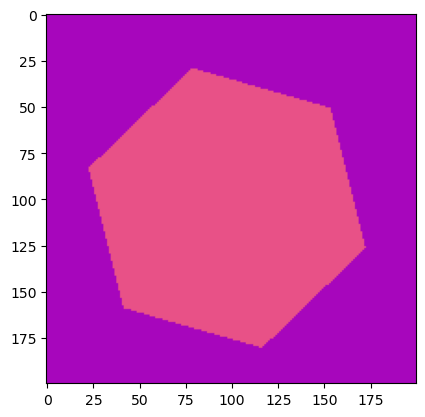

In [17]:
#cv2.imshow("image",images[1])
plt.imshow(images[0])
plt.show()

### Image preprocessing: b/w and scaling

To feed the images into the CNN for recognizing the family shape, I created a function to perform preprocessing steps on the images, to make the CNN more focused on the geometric family. Those steps are: 
1. create a mask to have the shape in white and the backgruond in black
2. scale the shape to the whole square. To do this, I cropped the largest square around the object and then resize the cropped image to the orignal size.

An exmaple of the steps is shown below.

Example of a new image


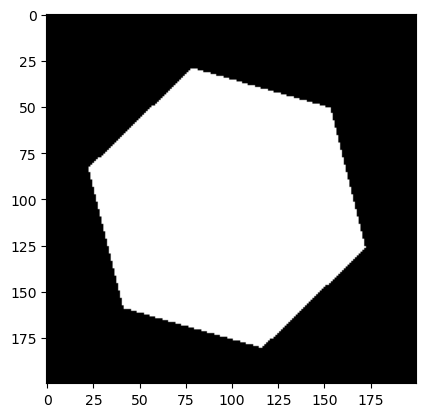

Example of square cut around ROI


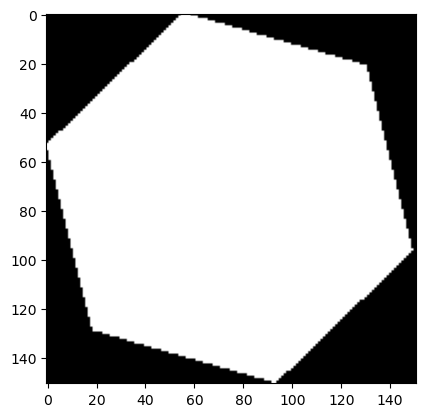

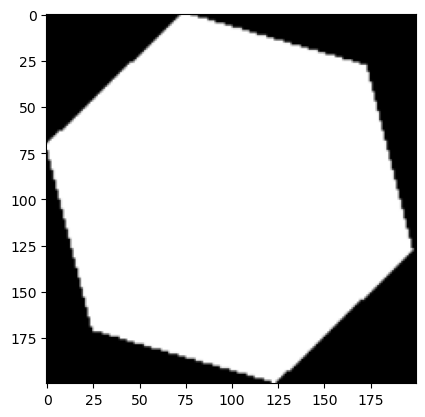

In [18]:
transformed_img_bn=image_preprocessing(images,color_Shape,npixel_w,npixel_h)

In [19]:
len(transformed_img_bn)

1000

In [20]:
classes = features["geometric_family"].unique()
classes

array(['Hexagon', 'Square', 'Star', 'Triangle', 'Nonagon', 'Octagon',
       'Heptagon', 'Pentagon', 'Circle'], dtype=object)

### Implementation of a CNN to infer geometric shape
The CNN is built using small number of neurons and the final dropout layer to avoid overfitting.

Prediction is done at the end, using the Softmax function to obtain probability for each class

In [21]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))


In [22]:
class GeometricShapeClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(1, 8, kernel_size = 5, padding = 1),
            nn.ReLU(),
            nn.Conv2d(8,16, kernel_size = 5, stride = 2, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(16, 32, kernel_size = 5, stride = 2, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.Linear(4608,32),
            nn.ReLU(),
            nn.Linear(32,9) #n. classes
        )
    
    def forward(self, xb):
        return self.network(xb)

In [23]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [24]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (8,4))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=8).permute(1,2,0))
        break

In [25]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [26]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [27]:
def predict(model, data):
    prediction  = torch.nn.Softmax(dim=0)
    
    pred_prob=[]
    pred_lab=[]
    for i in range(len(data)):
        pb=prediction(model(data)[i])
        pred_prob.append(pb)
        
        pl=np.argmax(pb.detach().numpy())
        pred_lab.append(pl)
    
    return(pred_lab,pred_prob)

In [28]:
model = GeometricShapeClassification()
model

GeometricShapeClassification(
  (network): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.5, inplace=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=4608, out_features=32, bias=True)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=9, bias=True)
  )
)

### Creation of train-validation datasets

In [29]:
batch_size =64

val_size= len(features)*20/100 #20% left as validation
train_size = len(features) - val_size 

# I need to associate the class to the img, to use the DataLoader
data_final = []
for i in range(len(features)):
   data_final.append([transformed_img_bn[i], features['geometric_family_numeric'][i]])

train_data, val_data = train_test_split(data_final,random_state=34, test_size=0.2)

trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
i1, l1= next(iter(trainloader))
print(i1.shape)

valloader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size)
i2, l2 = next(iter(valloader))
print(i2.shape)

torch.Size([64, 1, 200, 200])
torch.Size([64, 1, 200, 200])


Show some of the shapes in the train set (now they are all in b/w and scaled so the shapes fills the 200x200 square)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


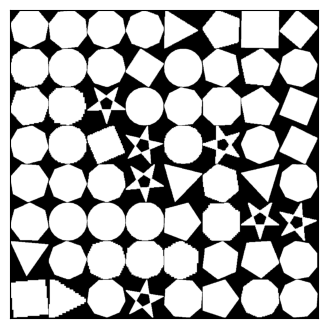

In [30]:
show_batch(trainloader)

### Fit the model on training data
Fit and check results after each epoc (accuracy on the validation set and losses on train and validation), to check if model overfits and if it reaches good performances.

In [31]:
num_epochs =20
opt_func = torch.optim.Adam
lr = 0.001

history = fit(num_epochs, lr, model, trainloader, valloader, opt_func)

Epoch [0], train_loss: 4.3976, val_loss: 1.8462, val_acc: 0.3047
Epoch [1], train_loss: 1.5059, val_loss: 0.9524, val_acc: 0.6484
Epoch [2], train_loss: 0.8461, val_loss: 0.5267, val_acc: 0.7773
Epoch [3], train_loss: 0.4913, val_loss: 0.3606, val_acc: 0.8516
Epoch [4], train_loss: 0.3980, val_loss: 0.2523, val_acc: 0.9141
Epoch [5], train_loss: 0.3294, val_loss: 0.2236, val_acc: 0.9180
Epoch [6], train_loss: 0.2973, val_loss: 0.1910, val_acc: 0.9219
Epoch [7], train_loss: 0.2790, val_loss: 0.1226, val_acc: 0.9648
Epoch [8], train_loss: 0.2443, val_loss: 0.1424, val_acc: 0.9766
Epoch [9], train_loss: 0.2282, val_loss: 0.0856, val_acc: 0.9805
Epoch [10], train_loss: 0.2128, val_loss: 0.1037, val_acc: 0.9727
Epoch [11], train_loss: 0.2080, val_loss: 0.0621, val_acc: 0.9844
Epoch [12], train_loss: 0.1282, val_loss: 0.0750, val_acc: 0.9688
Epoch [13], train_loss: 0.1157, val_loss: 0.0427, val_acc: 0.9844
Epoch [14], train_loss: 0.1296, val_loss: 0.1328, val_acc: 0.9492
Epoch [15], train_lo

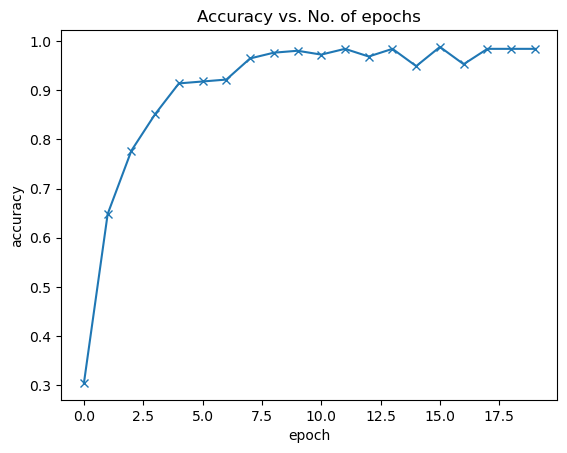

In [32]:
plot_accuracies(history)

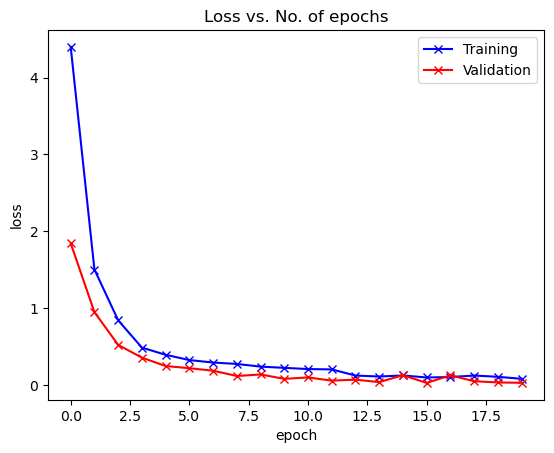

In [33]:
plot_losses(history)

### Test set: prediciton of shape and similarity check

Now, that the CNN to infer the geometric family works withot overfitting and with an high accuracy, it is possible to associate a geometric family to an input image. 

Once that this is done, to choose the most similar images within the same geometric family, it is possible to compare the features (color, dimension) of the image with those of its family.
For this step I used a weighted euclidean distance, giving a higher weight to:
1. shape color (weight=2)
2. dimension (weight=1)
3. gravity center (weight=1)
4. background color (weight=0.5)

In [34]:
fn_test=np.random.choice(filenames,10)

In [35]:
preproc_test=preprocessing(fn_test)

In [36]:
images_test=preproc_test[0]
features_test=preproc_test[1]
color_Shape_test=preproc_test[2]

In [37]:
features_test

,filepath,filename,geometric_family,shape_area,geometric_family_numeric,shape_R,shape_G,shape_B,background_R,background_G,background_B,shape_center_y,shape_center_x
0,/Users/ieo4991/Desktop/Image_similarity/data/N...,Nonagon_ba6c498a-2a85-11ea-8123-8363a7ec19e6.png,Nonagon,9822,0,13,115,232,183,213,197,111.354918,85.483608
1,/Users/ieo4991/Desktop/Image_similarity/data/H...,Hexagon_0adbe7de-2a8d-11ea-8123-8363a7ec19e6.png,Hexagon,8529,1,142,206,131,144,181,184,125.502990,103.909954
2,/Users/ieo4991/Desktop/Image_similarity/data/O...,Octagon_bd674de8-2a84-11ea-8123-8363a7ec19e6.png,Octagon,8232,2,199,174,161,233,53,197,76.587464,120.243440
3,/Users/ieo4991/Desktop/Image_similarity/data/O...,Octagon_57d50a04-2a90-11ea-8123-8363a7ec19e6.png,Octagon,12293,2,238,231,70,211,133,4,98.331083,94.145205
4,/Users/ieo4991/Desktop/Image_similarity/data/S...,Square_b04eeada-2a89-11ea-8123-8363a7ec19e6.png,Square,4140,3,243,5,116,234,207,86,116.809179,115.909662
5,/Users/ieo4991/Desktop/Image_similarity/data/T...,Triangle_c21bcffc-2a8a-11ea-8123-8363a7ec19e6.png,Triangle,224,4,203,15,86,47,162,0,125.428571,108.517857
6,/Users/ieo4991/Desktop/Image_similarity/data/S...,Square_ceb1c9fc-2a84-11ea-8123-8363a7ec19e6.png,Square,4138,3,112,252,65,172,91,96,79.863461,100.675205
7,/Users/ieo4991/Desktop/Image_similarity/data/S...,Square_1a209f44-2a85-11ea-8123-8363a7ec19e6.png,Square,5872,3,230,63,207,216,159,68,100.494210,84.362057
8,/Users/ieo4991/Desktop/Image_similarity/data/S...,Square_e185e37a-2a83-11ea-8123-8363a7ec19e6.png,Square,441,3,169,16,181,57,178,234,150.505669,111.571429
9,/Users/ieo4991/Desktop/Image_similarity/data/S...,Square_61e40378-2a8c-11ea-8123-8363a7ec19e6.png,Square,7640,3,21,115,135,107,61,223,128.757461,85.450524


Example of a new image


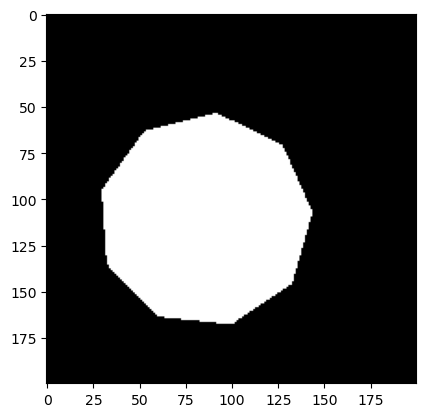

Example of square cut around ROI


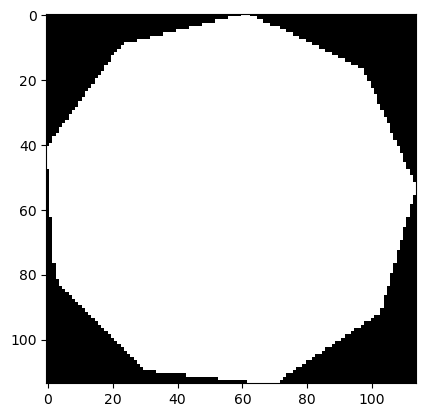

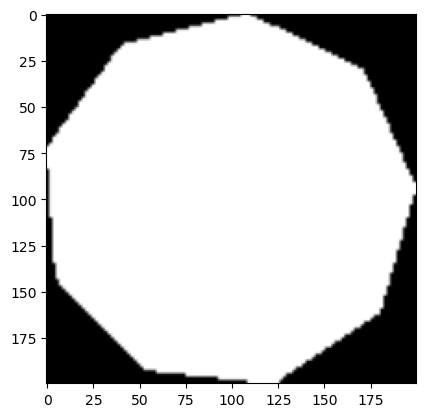

In [38]:
transformed_img_bn_test=image_preprocessing(images_test,color_Shape_test,npixel_w,npixel_h)

In [39]:
data_final_test = []
data_final1 = []
for i in range(len(features_test)):
   data_final_test.append([transformed_img_bn_test[i], features_test['geometric_family_numeric'][i]])
   data_final1.append([transformed_img_bn_test[i], features_test['geometric_family_numeric'][i],features_test['filename'][i]])

testloader = torch.utils.data.DataLoader(data_final_test, shuffle=False, batch_size=len(features_test))
i3, l3 = next(iter(testloader))
print(i3.shape)

#load also those with name
testloader_n = torch.utils.data.DataLoader(data_final1, shuffle=False, batch_size=len(features_test))
i3_n, l3_n, f3_n = next(iter(testloader_n))
print(i3_n.shape)

torch.Size([10, 1, 200, 200])
torch.Size([10, 1, 200, 200])


In [40]:
preds=predict(model,i3)

In [41]:
dpred = {'Real class':l3,
    'Predicted class':preds[0],
         'Real_class_name':l3_n,
         'Filename':f3_n
    }
df_prediciton=pd.DataFrame(dpred)

df_prediciton

,Real class,Predicted class,Real_class_name,Filename
0,0,4,0,Nonagon_ba6c498a-2a85-11ea-8123-8363a7ec19e6.png
1,1,0,1,Hexagon_0adbe7de-2a8d-11ea-8123-8363a7ec19e6.png
2,2,5,2,Octagon_bd674de8-2a84-11ea-8123-8363a7ec19e6.png
3,2,5,2,Octagon_57d50a04-2a90-11ea-8123-8363a7ec19e6.png
4,3,1,3,Square_b04eeada-2a89-11ea-8123-8363a7ec19e6.png
5,4,3,4,Triangle_c21bcffc-2a8a-11ea-8123-8363a7ec19e6.png
6,3,1,3,Square_ceb1c9fc-2a84-11ea-8123-8363a7ec19e6.png
7,3,1,3,Square_1a209f44-2a85-11ea-8123-8363a7ec19e6.png
8,3,1,3,Square_e185e37a-2a83-11ea-8123-8363a7ec19e6.png
9,3,1,3,Square_61e40378-2a8c-11ea-8123-8363a7ec19e6.png


Check figure  0
Original Image:


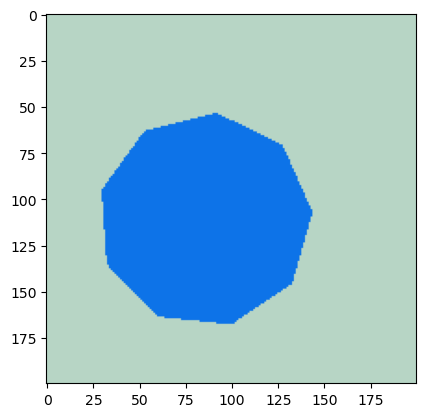

Most similar ones


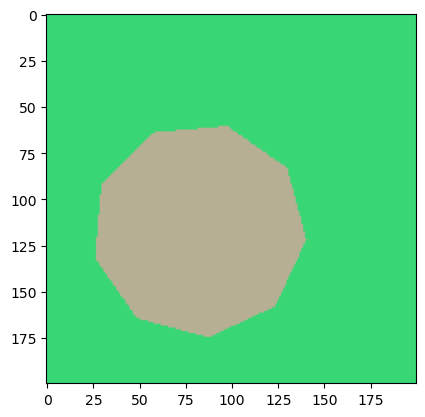

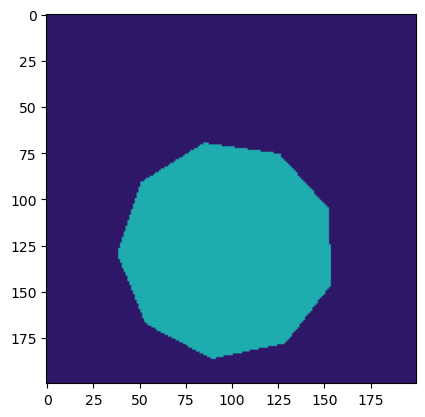

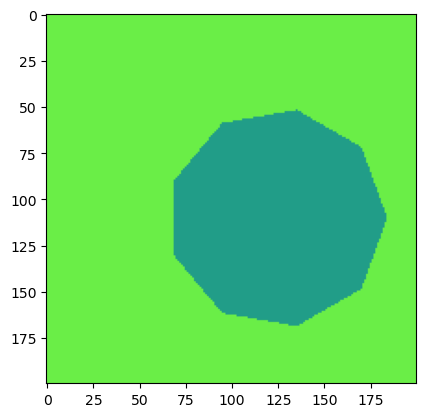

Check figure  1
Original Image:


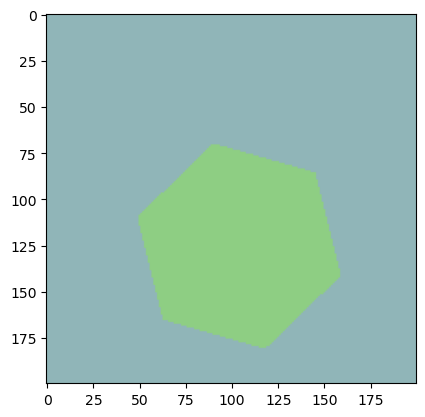

Most similar ones


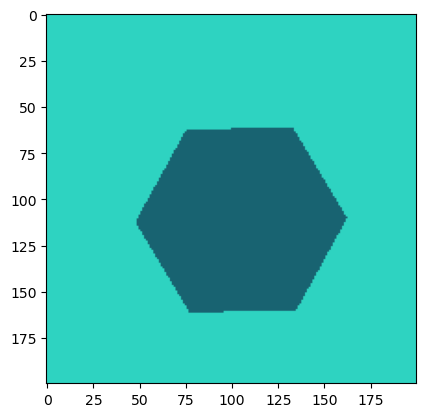

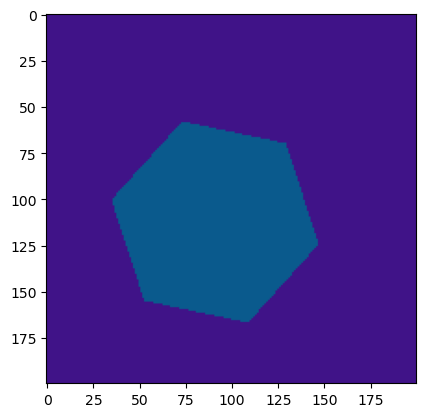

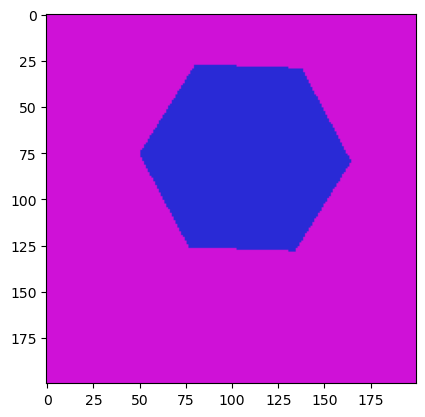

Check figure  2
Original Image:


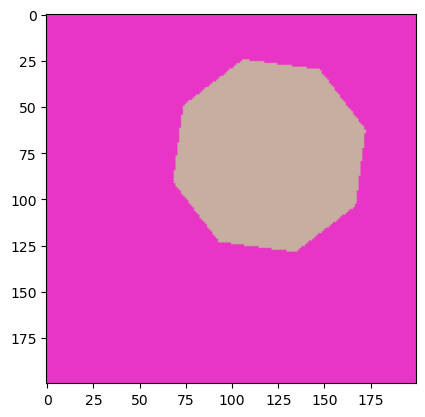

Most similar ones


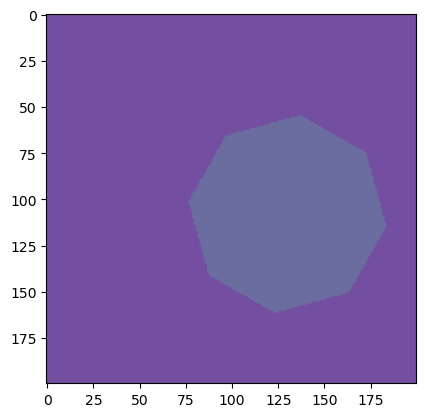

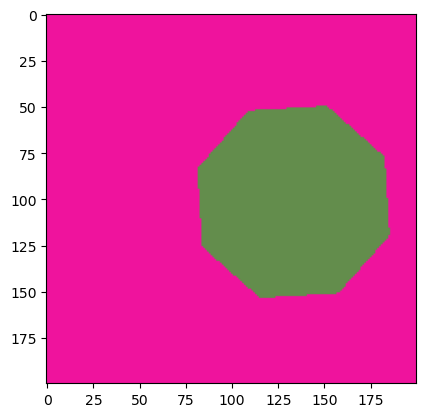

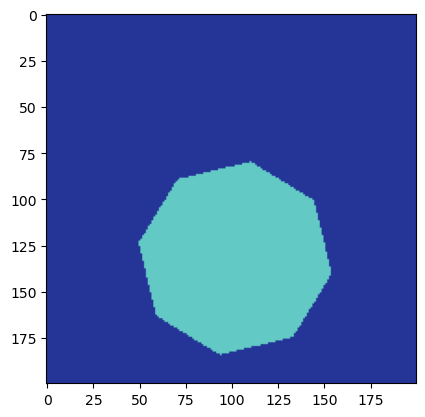

Check figure  3
Original Image:


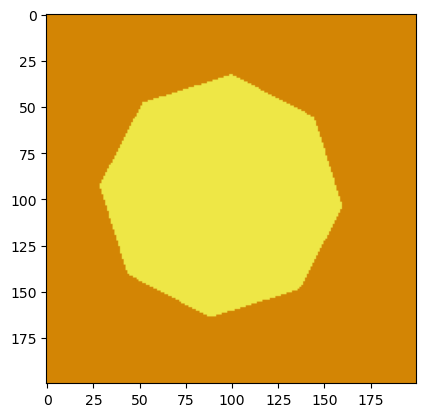

Most similar ones


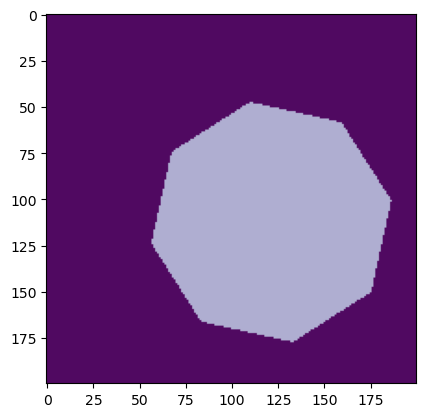

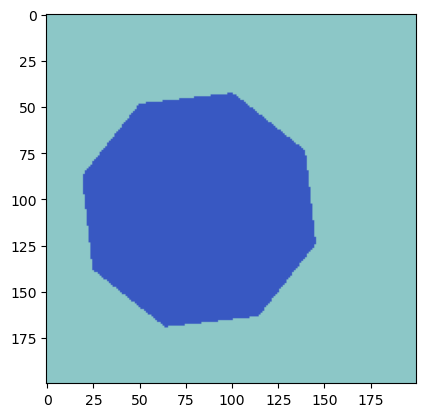

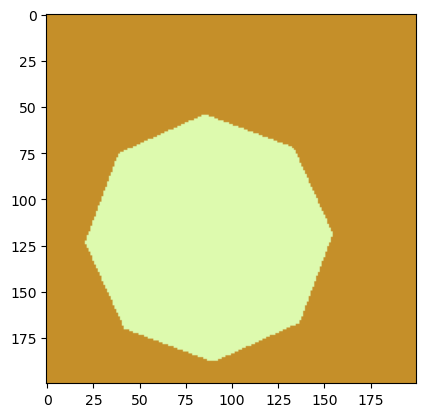

Check figure  4
Original Image:


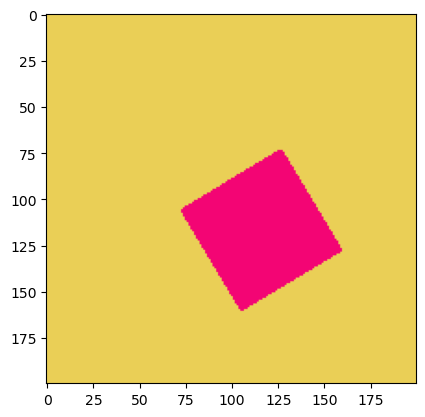

Most similar ones


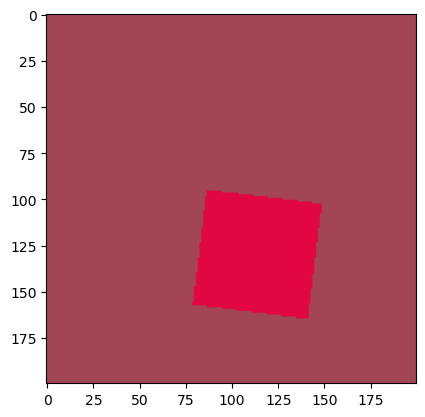

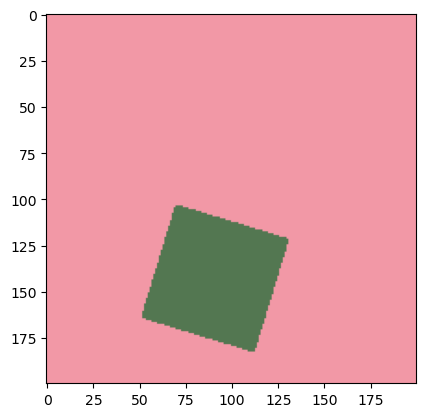

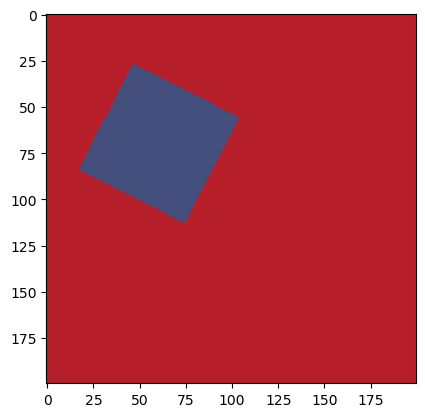

Check figure  5
Original Image:


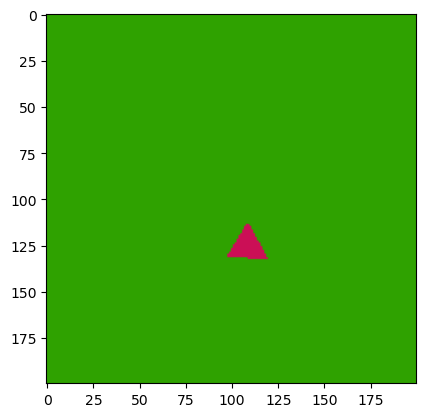

Most similar ones


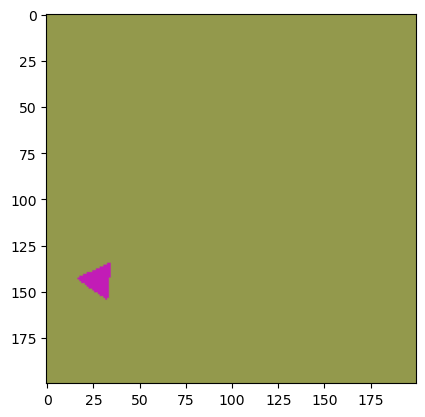

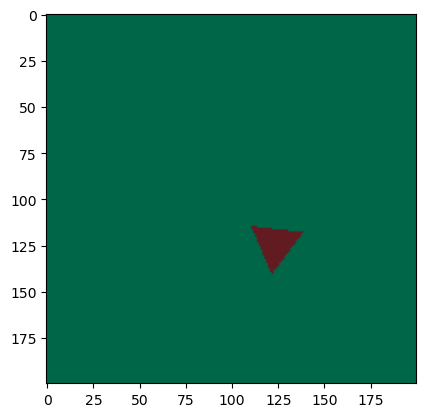

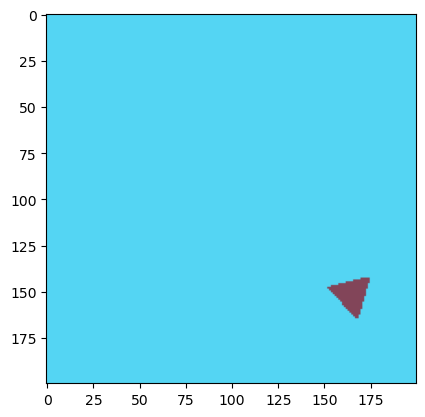

Check figure  6
Original Image:


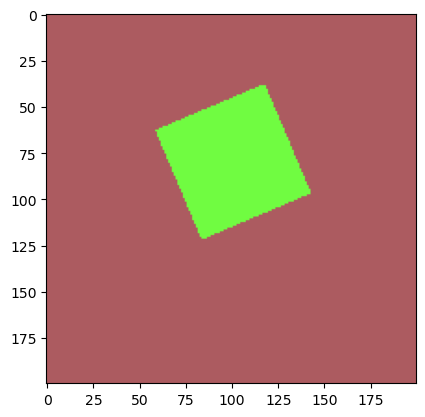

Most similar ones


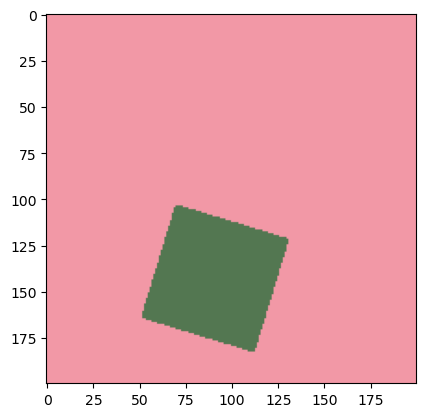

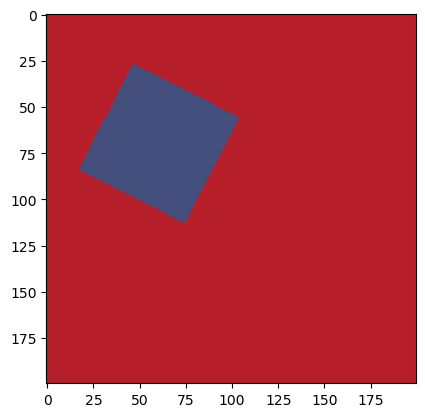

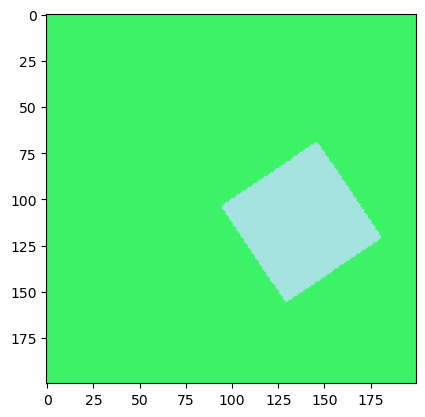

Check figure  7
Original Image:


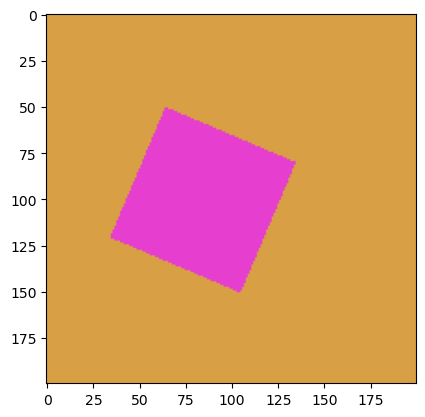

Most similar ones


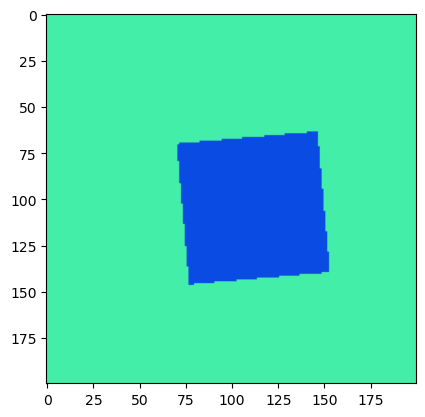

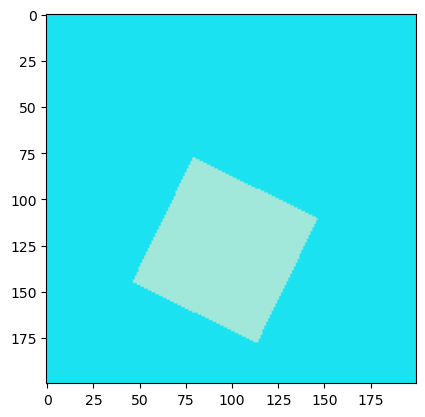

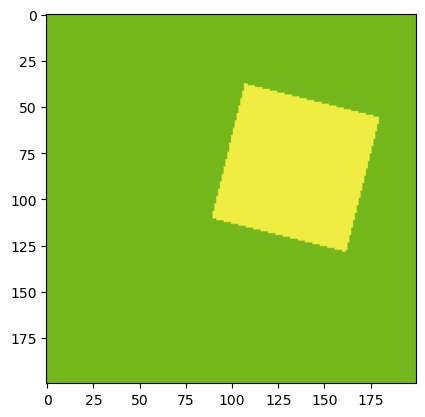

Check figure  8
Original Image:


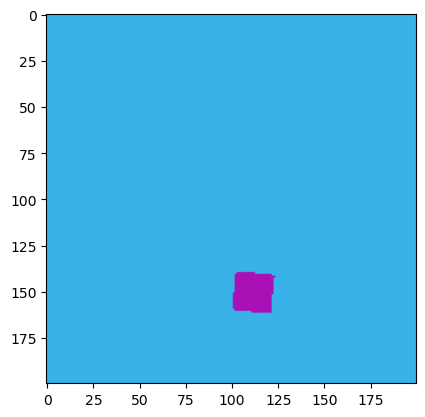

Most similar ones


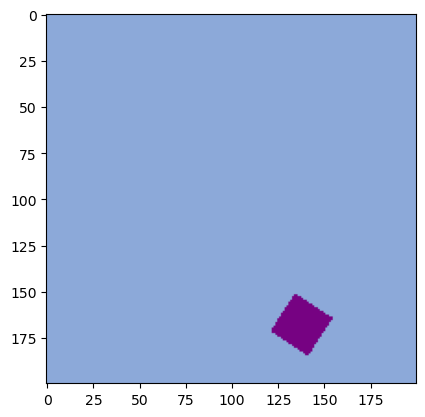

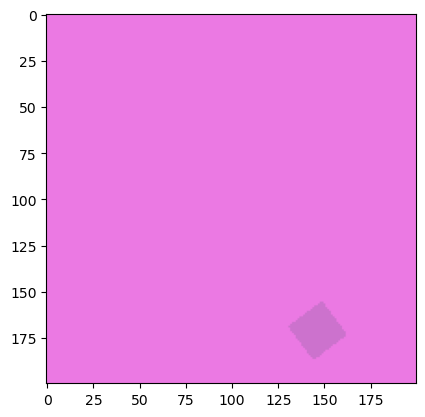

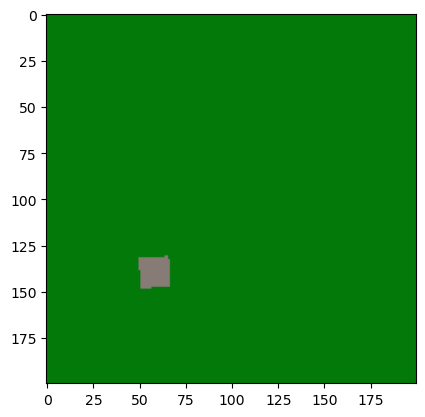

Check figure  9
Original Image:


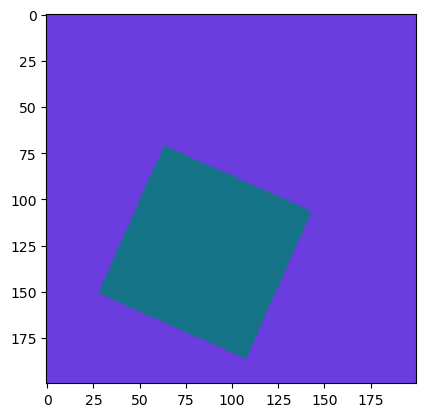

Most similar ones


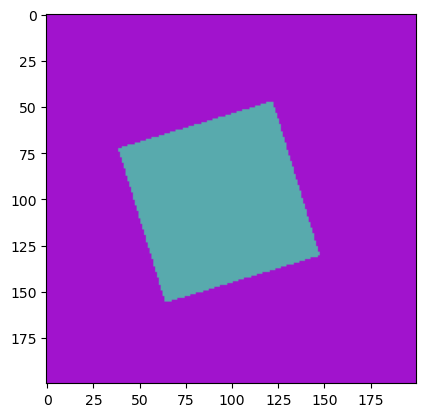

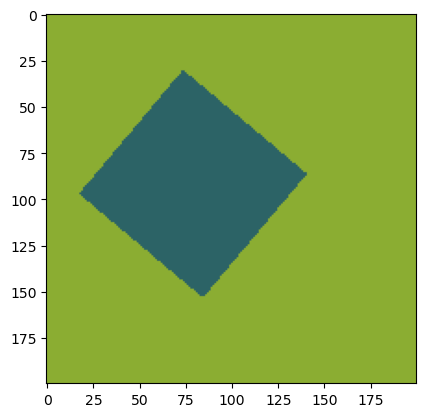

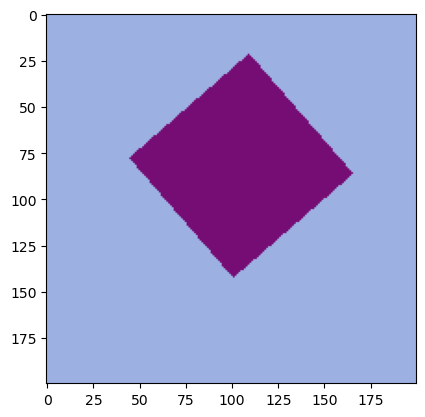

In [62]:
for i in range(len(df_prediciton)):
    
    print("Check figure ",i)
        
    chosen_class=df_prediciton['Predicted class'][i]
    name=df_prediciton['Filename'][i]
     
    feat_chosen=features_test[features_test['filename']==name]
    feat_chosen
     
    #select only elements in the train part which are in the predicted class
    features_sel=features[features['geometric_family_numeric']==chosen_class]
    features_sel.head()
     
    dist_eu=[]
    for index, row in features_sel.iterrows():
        fc=feat_chosen.drop(columns=['filepath','geometric_family','filename']).values.flatten()
        fs=features_sel.loc[index, 'shape_area':'shape_center_x'].values.flatten()
                               
    #define weights: 
        weigths=[1,2,1,0.5]
        dist_w=weightedL2(fc,fs,[1,0,2,2,2,0.5,0.5,0.5,1,1])
     
        dist_eu.append(dist_w)
     
     #return the 3 most similar images
    argmin=np.array(dist_eu).argsort()[:3]
     
    print("Original Image:")
    
    fn1=feat_chosen['filepath'].iloc[0]
    original=cv2.imread(fn1)
    plt.imshow(original)
    plt.show()
     
    print("Most similar ones")
     
    for fn in features_sel['filepath'].iloc[argmin]:
        ck = cv2.imread(fn)
        plt.imshow(ck)
        plt.show()
     